In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
data = data[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

## EDA

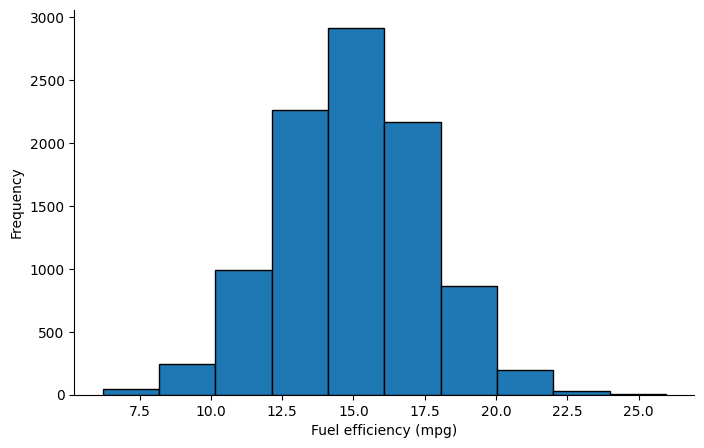

In [3]:
plt.figure(figsize=(8, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.hist(data['fuel_efficiency_mpg'], edgecolor='black')
plt.xlabel("Fuel efficiency (mpg)")
plt.ylabel("Frequency")
plt.show()

## 1. Column with missing values

In [4]:
data.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

## 2. Median for horsepower

In [5]:
data['horsepower'].median()

np.float64(149.0)

## Data preparation

In [6]:
n = len(data)
n_val = int(n * .2)
n_test = int(n * .2)
n_train = n - n_val - n_test

rand_indexes = list(data.index)

np.random.seed(42)
np.random.shuffle(rand_indexes)

df_train = data.iloc[rand_indexes[:n_train]]
df_val = data.iloc[rand_indexes[n_train:n_train + n_val]]
df_test = data.iloc[rand_indexes[n_train + n_val:]]

## 3. Evaluate filling methods

In [7]:
def train_linear_regression(X: pd.DataFrame, y: pd.Series):
    ones = np.ones(X.shape[0])

    X = np.column_stack([ones, X])
    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w_full = (XTX_inv @ X.T) @ y

    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    squared_error = (y - y_pred) ** 2
    mse = squared_error.mean()
    return np.sqrt(mse)

### 3.1. Filling with zero

In [8]:
zero_fill = df_train.fillna(0)

X_train = zero_fill.drop('fuel_efficiency_mpg', axis=1)
y_train = zero_fill['fuel_efficiency_mpg']

intercept, weights = train_linear_regression(X_train, y_train)

y_pred = intercept + X_train.dot(weights)

print("train dataset:", round(rmse(y_train, y_pred), 2))

train dataset: 0.52


In [9]:
zero_fill_val = df_val.fillna(0)
X_val = zero_fill_val.drop('fuel_efficiency_mpg', axis=1)
y_val = zero_fill_val['fuel_efficiency_mpg']

y_pred = intercept + X_val.dot(weights)
print("validation dataset:", round(rmse(y_val, y_pred), 2))

validation dataset: 0.52


### 3.2 Filling with mean

In [10]:
hp_mean = df_train['horsepower'].mean()
hp_mean_train = df_train.fillna(hp_mean)

X_train = hp_mean_train.drop('fuel_efficiency_mpg', axis=1)
y_train = hp_mean_train['fuel_efficiency_mpg']

intercept, weights = train_linear_regression(X_train, y_train)

y_pred = intercept + X_train.dot(weights)
print("train dataset:", round(rmse(y_train, y_pred), 2))

train dataset: 0.46


In [11]:
hp_mean_val = df_val.fillna(hp_mean)

X_val = hp_mean_val.drop('fuel_efficiency_mpg', axis=1)
y_val = hp_mean_val['fuel_efficiency_mpg']

y_pred = intercept + X_val.dot(weights)
print("validation dataset", round(rmse(y_val, y_pred), 2))


validation dataset 0.46


## 4. Evaluating with regularized regression

In [ ]:
def train_linear_regression_reg(X: pd.DataFrame, y: pd.Series, r: float):
    ones = np.ones(X.shape[0])

    X = np.column_stack([ones, X])
    XTX = X.T @ X
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = (XTX_inv @ X.T) @ y

    return w_full[0], w_full[1:]


regs = [0, 0.01, 0.1, 1, 5, 10, 100]

X_train = df_train.drop('fuel_efficiency_mpg', axis=1).fillna(0)
X_val = df_val.drop('fuel_efficiency_mpg', axis=1).fillna(0)

y_train = df_train['fuel_efficiency_mpg']
y_val = df_val['fuel_efficiency_mpg']

for r in regs:
    intercept, weights = train_linear_regression_reg(X_train, y_train, r)

    y_pred = intercept + X_val.dot(weights)
    score = rmse(y_val, y_pred)

    print(f"r value: {r} - rmse score: {score:.2f}")

r value: 0 - rmse score: 0.52
r value: 0.01 - rmse score: 0.52
r value: 0.1 - rmse score: 0.52
r value: 1 - rmse score: 0.52
r value: 5 - rmse score: 0.52
r value: 10 - rmse score: 0.52
r value: 100 - rmse score: 0.52


## 5. Trying different seeds

In [13]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for s in seeds:
    indexes = list(data.index)

    np.random.seed(s)
    np.random.shuffle(indexes)

    df_train = data.iloc[indexes[:n_train]]
    df_val = data.iloc[indexes[n_train:n_train + n_val]]
    df_test = data.iloc[indexes[n_train + n_val:]]

    X_train = df_train.drop('fuel_efficiency_mpg', axis=1).fillna(0)
    X_val = df_val.drop('fuel_efficiency_mpg', axis=1).fillna(0)
    y_train = df_train['fuel_efficiency_mpg']
    y_val = df_val['fuel_efficiency_mpg']

    intercept, weights = train_linear_regression(X_train, y_train)

    y_pred = intercept + X_val.dot(weights)
    rmse_scores.append(rmse(y_val, y_pred))

round(np.std(rmse_scores), 3)

np.float64(0.007)

## 6. Evaluating on test dataset

In [14]:
indexes = list(data.index)

np.random.seed(9)
np.random.shuffle(indexes)

df_train_val = data.iloc[indexes[:n_test + n_val]]
df_test = data.iloc[indexes[n_test + n_val:]]

X_train_val = df_train_val.drop('fuel_efficiency_mpg', axis=1).fillna(0)
X_test = df_test.drop('fuel_efficiency_mpg', axis=1).fillna(0)
y_train_val = df_train_val['fuel_efficiency_mpg']
y_test = df_test['fuel_efficiency_mpg']

intercept, weights = train_linear_regression_reg(X_train_val, y_train_val, 0.001)

y_pred = intercept + X_test.dot(weights)

rmse(y_test, y_pred)

np.float64(0.51831020260556)